In [25]:
%matplotlib inline
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers
import pygsp as pg
import networkx as nx

# import our own functions
from our_functions import get_true_labels, find_components, find_largest_component, \
give_names_tonodes_dates_based, num_nodes, connected_graph, compute_clustering_coefficient
import random

# Extracting Terrorist Names from Nodes

In [2]:
A = np.load('adjacency.npy')

# get the largest component
A, size = find_largest_component(find_components(A))

n_nodes = size
n_edges = np.count_nonzero(A) / 2

# get terrorist names for each node
names, A, name_dict = give_names_tonodes_dates_based(A)

# get relation label for each node
labels = get_true_labels(A)

# Graph Inversion

Number of unique terrorist: 244


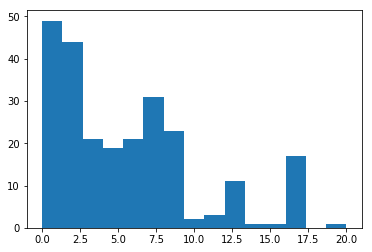

In [3]:
# Number of unique terrorists
num_terrorist = len(name_dict.keys())
print("Number of unique terrorist: {n:}".format(n=num_terrorist))

# Array of terrorist names 
all_names = np.array(list(name_dict.keys()))

# Initialize inverted adjacency matrix. Symmetric and unweighted by default.
A_inverted = np.zeros((num_terrorist, num_terrorist))
A_relations = np.zeros((num_terrorist, num_terrorist))

for n in range(n_nodes):
    temp = []
    for d, name in enumerate(list(name_dict.keys())):
        if n in list(name_dict.values())[d]:
            # collect all terrorist names that correspond to node n: will ALWAYS be at most length 2
            temp.append(list([name]))

    for k in range(len(temp)):
        for j in range(len(temp)):
            if k >= j: continue
            idx = np.where(all_names == temp[k])[0][0]
            idx2 = np.where(all_names == temp[j])[0][0]
            
            # create an edge between all terrorists that belonged to the same node in original graph
            A_inverted[idx,idx2] = 1
            A_inverted[idx2,idx] = 1
            
            # create a matrix which stores corresponding relations between terrorists             
            A_relations[idx,idx2] = int(labels[n])
            A_relations[idx2,idx] = int(labels[n])
            
plt.hist(np.sum(A_inverted,axis=1), bins=15)
plt.show()

### Largest Component of Inverted Graph

Number of disconnected components: 30


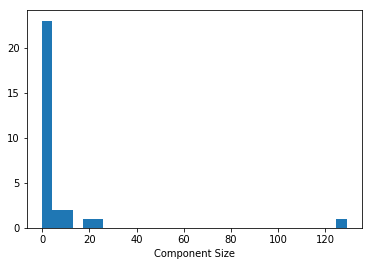

Size of inverted graph: 244
Size of largest component: 129


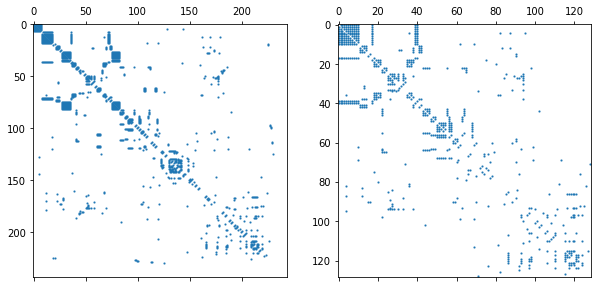

In [4]:
# Find the largest component
components = find_components(A_inverted)
largest_cc_inv, size = find_largest_component(components)

# Remove all-zero indices
zero_index = np.where(np.sum(largest_cc_inv, axis=0) == 0)[0]
largest_cc_inv = np.delete(largest_cc_inv, zero_index, axis=0)
largest_cc_inv = np.delete(largest_cc_inv, zero_index, axis=1)
relations_largest_cc = np.delete(A_relations, zero_index, axis=0)
relations_largest_cc = np.delete(relations_largest_cc, zero_index, axis=1)
names_largest_cc = np.delete(all_names, zero_index)

print("Number of disconnected components: {d:}".format(d=len(components)))
deg_dist = []
for c in range(len(components)):
    deg_dist.append(num_nodes(components[c]))

plt.hist(deg_dist, bins=len(components))
plt.xlabel('Component Size')
plt.show()

print("Size of inverted graph: {s:}".format(s=num_terrorist))
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
ax1.spy(A_inverted, markersize=1)

print("Size of largest component: {s:}".format(s=size))
ax2 = fig.add_subplot(122)
ax2.spy(largest_cc_inv, markersize=1)

In [5]:
display = False
if display:
    for idx, name in enumerate(names):
        print(name)
        for i in range(A.shape[0]):
            if A[idx, i] == 1:
                print("\t"+str(names[i]))

# Generate Feature Vectors for Largest Component
Each node shall be described by its:
- degree
- local clustering coefficient
- closeness centrality
- betweenness centrality
- smoothness of a Dirac impulse placed over it
- probability as discovered by applying the probability transition matrix many times
- four (4) indicator variables indicating what types of relations its edges have (family, colleague, contact, congregate)

### Degree centrality

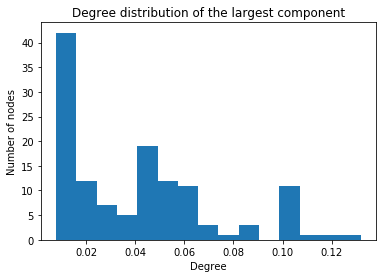

In [53]:
degrees = np.sum(largest_cc_inv,axis=1) / largest_cc_inv.shape[0]
plt.hist(degrees, bins=15)
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.title("Degree distribution of the largest component")
plt.show()

### Local clustering coefficient

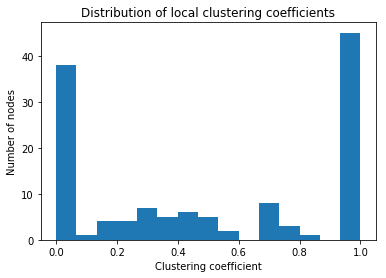

In [31]:
clus_coeff = np.empty(largest_cc_inv.shape[0])
for n in range(largest_cc_inv.shape[0]):
    clus_coeff[n] = compute_clustering_coefficient(largest_cc_inv, n)

plt.hist(clus_coeff, bins=15)
plt.xlabel("Clustering coefficient")
plt.ylabel("Number of nodes")
plt.title("Distribution of local clustering coefficients")
plt.show()

### Closeness centrality

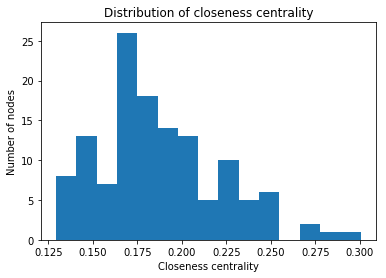

In [48]:
G = nx.from_numpy_matrix(largest_cc_inv)
closeness = np.array(list(nx.closeness_centrality(G).values()))
plt.hist(closeness, bins=15)
plt.xlabel("Closeness centrality")
plt.ylabel("Number of nodes")
plt.title("Distribution of closeness centrality")
plt.show()

### Betweenness centrality

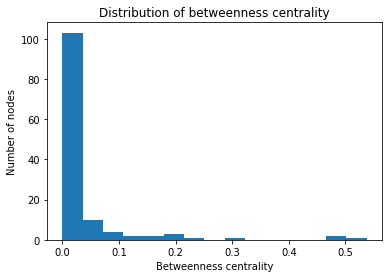

In [56]:
between = np.array(list(nx.betweenness_centrality(G).values()))
plt.hist(between, bins=15)
plt.xlabel("Betweenness centrality")
plt.ylabel("Number of nodes")
plt.title("Distribution of betweenness centrality")
plt.show()

### Smoothness of Dirac placed over each node (do not use)
Turns out this is identical to node degree distribution! (so we should only use one or the other)

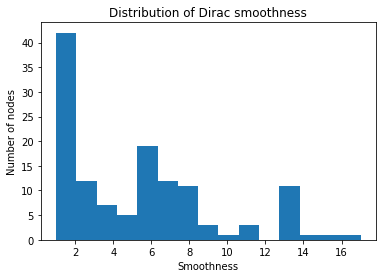

In [66]:
# Compute Laplacian
D = np.diag(largest_cc_inv.sum(axis=1))
L = D - largest_cc_inv

smoothness = np.empty(largest_cc_inv.shape[0])
for n in range(largest_cc_inv.shape[0]):
    # define dirac impulse
    dirac = np.zeros(largest_cc_inv.shape[0])
    dirac[n] = 1
    
    # compute smoothness using Laplacian; smaller means more smooth
    smoothness[n] = dirac.T @ L @ dirac

plt.hist(smoothness, bins=15)
plt.xlabel("Smoothness")
plt.ylabel("Number of nodes")
plt.title("Distribution of Dirac smoothness")
plt.show()

### Indicator variables

In [124]:
# Identify nodes which have edges with a specific relations label
nodes_fam = list((set(np.where(relations_largest_cc == -2)[0])))
nodes_cong = list((set(np.where(relations_largest_cc == -1)[0])))
nodes_coll = list((set(np.where(relations_largest_cc == 1)[0])))
nodes_cont = list((set(np.where(relations_largest_cc == 2)[0])))

# Create indicator variables for each relations label
ind_fam = np.zeros(largest_cc_inv.shape[0])
ind_cong = np.zeros(largest_cc_inv.shape[0])
ind_coll = np.zeros(largest_cc_inv.shape[0])
ind_cont = np.zeros(largest_cc_inv.shape[0])

ind_fam[nodes_fam] = 1
ind_cong[nodes_cong] = 1
ind_coll[nodes_coll] = 1
ind_cont[nodes_cont] = 1